In [1]:
import inspect
import L96_model
import matplotlib.pyplot as plt
import numpy as np

Equation 1 from [Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) is:
\begin{align}
\frac{d}{dt} X_k &= - X_{k-2} X_{k-1} + X{k-1} X_{k+1} - X_k + F
\end{align}
where $F$ is a constant independent of $k=0,1,2,\ldots,K-1$ (using python indexing starting at k=0). The $k$ index is periodic so that, for example, $k=K$ is referring to $k=0$ and $k=-1$ is referring to $k=K-1$.

The following function returns the rate of change $\frac{d}{dt} X_j$:

In [2]:
from L96_model import L96_eq1_xdot
print( inspect.getsource(L96_eq1_xdot) )

def L96_eq1_xdot(X, t, F):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 1:
        d/dt X[k] = -X[k-2] X[k-1] + X[k-1] X[k+1] - X[k] + F

    Args:
        X : Values of X variables at the current time step
        t : Time
        F : Forcing term
    Returns:
        dXdt : Array of X time tendencies
    """

    K = len(X)
    Xdot = np.zeros(K)
    
    for k in range(K):
        Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F
    return Xdot



We can use different numerical schemes for integrations (to be investigated). Below is an example using 4th order Runge-Kutta. 

In [3]:
from L96_model import RK4
print( inspect.getsource(RK4) )

def RK4(fn, dt, X, t, *params):
    """
    Calculate the new state X(n+1) for d/dt X = fn(X,t,...) using the fourth order Runge-Kutta method.

    Args:
        fn     : The function returning the time rate of change of model variables X
        dt     : The time step
        X      : Values of X variables at the current time, t
        t      : Time at beginning of time step
        params : All other arguments that should be passed to fn, i.e. fn(X, t, *params)

    Returns:
        X at t+dt
    """
    Xdot1 = fn(X, t, *params)
    Xdot2 = fn(X+0.5*dt*Xdot1, t+0.5*dt, *params)
    Xdot3 = fn(X+0.5*dt*Xdot2, t+0.5*dt, *params)
    Xdot4 = fn(X+dt*Xdot3, t+dt, *params)
    return X + (dt/6.) * ( ( Xdot1 + Xdot4 ) + 2. * ( Xdot2 + Xdot3 ) )



To use the model we add a "time loop", iterating over consecutive values of time passing forward the model state from time level $n$ to obtain the state at time level $n+1$. We assume a fixed time step, $\Delta t$ so that $t(n) = n\Delta t$.

In [4]:
from L96_model import integrator_1d
print( inspect.getsource(integrator_1d) )

def integrator_1d(fn, method, dt, X0, nt, *params):
    """
    Integrates forward-in-time the model "fn" using the integration "method". Returns the full history with
    nt+1 values including initial conditions for n=0. The model "fn" is required to have one vector of state
    variables, X, and take the form fn(X, t, *params) where t is current model time.
    
    Args:
        fn     : The function returning the time rate of change of model variables X
        method : The time-stepping method that returns X(n+1) givein X(n)
        dt     : The time step
        X0     : Values of X variables at the current time
        nt     : Number of forwards steps
        params : All other arguments that should be passed to fn

    Returns:
        X[:,:], time[:] : the full history X[n,k] at times t[n]
    """    
    time, hist = np.zeros((nt+1)), np.zeros((nt+1,len(X0)))
    X = X0.copy()
    hist[0,:] = X
    for n in range(nt):
        X = method( fn, dt, X, n*dt, *params )
        hi

We need some non-uniform initial conditions. These are often chosen as random numbers (which works) but in the interests of reproducible results we prescribe a simple periodic function (a sine would do but a cubic is more precisely reproducible for interval -1..+1).

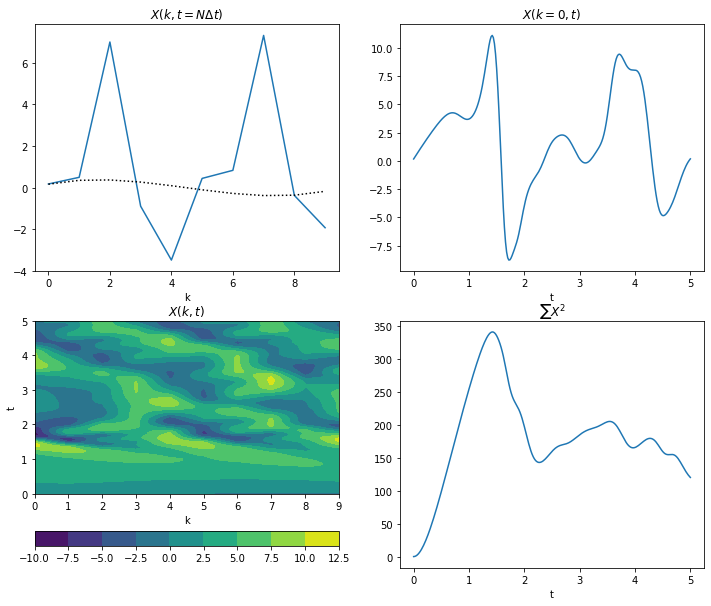

In [5]:
K = 10 # Number of degrees of freedom
nt = 250 # Number of time steps
dt = 0.02 # time step
F = 8.0 # Model parameter

# Initial conditions
k = np.arange(K) # For coordinate in plots
s = 2 * ( 0.5 + k ) / K - 1 # A symmetric coordinate from -1..+1
Xinit = s*(s-1)*(s+1) # Initial conditions

# "Run" model
X,t = integrator_1d(L96_eq1_xdot, RK4, dt, Xinit, nt, F)

plt.figure(figsize=(12,10))
plt.subplot(221); # Snapshot of X[k]
plt.plot(k, X[-1]); plt.xlabel('k'); plt.title('$X(k,t=N\Delta t)$');
plt.plot(k, Xinit, 'k:')
plt.subplot(222); # Sample time-series X[0](t)
plt.plot(t, X[:,0]); plt.xlabel('t'); plt.title('$X(k=0,t)$');
plt.subplot(223); # Full model history
plt.contourf(k,t,X); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$X(k,t)$');
plt.subplot(224); # Metric, total model energy
plt.plot(t, (X**2).sum(axis=-1)); plt.xlabel('t'); plt.title('$\sum X^2$');

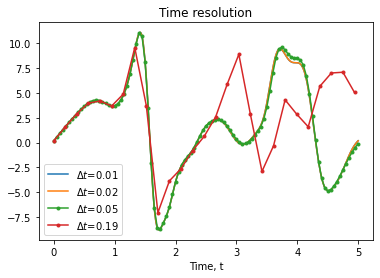

In [6]:
Xrk4_001,t001 = integrator_1d(L96_eq1_xdot, RK4, 0.01, Xinit, 500, F)
Xrk4_002,t002 = integrator_1d(L96_eq1_xdot, RK4, 0.02, Xinit, 250, F)
Xrk4_005,t005 = integrator_1d(L96_eq1_xdot, RK4, 0.05, Xinit, 100, F)
Xrk4_019,t019 = integrator_1d(L96_eq1_xdot, RK4, 0.19, Xinit, 26, F)

plt.plot(t001, Xrk4_001[:,0], label='$\Delta t$=0.01')
plt.plot(t002, Xrk4_002[:,0], label='$\Delta t$=0.02')
plt.plot(t005, Xrk4_005[:,0], '.-', label='$\Delta t$=0.05')
plt.plot(t019, Xrk4_019[:,0], '.-', label='$\Delta t$=0.19')
plt.legend()
plt.xlabel('Time, t'); plt.title('Time resolution');

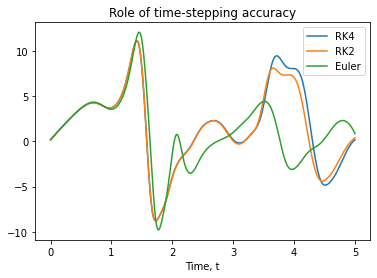

In [7]:
from L96_model import RK2, EulerFwd

dt, nt = 0.01, 500
Xrk4,t = integrator_1d(L96_eq1_xdot, RK4, dt, Xinit, nt, F)
Xrk2,_ = integrator_1d(L96_eq1_xdot, RK2, dt, Xinit, nt, F)
Xef,_ = integrator_1d(L96_eq1_xdot, EulerFwd, dt, Xinit, nt, F)

plt.plot(t, Xrk4[:,0], label='RK4')
plt.plot(t, Xrk2[:,0], label='RK2')
plt.plot(t, Xef[:,0], label='Euler')
plt.legend()
plt.xlabel('Time, t'); plt.title('Role of time-stepping accuracy');

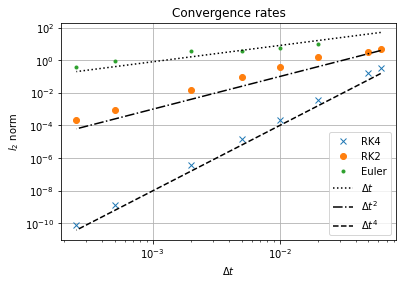

In [8]:
def l2nrm(X,Xtrth):
    return np.sqrt( ( ( X[-1,:] - Xtrth[-1,:] )**2 ).mean() )

NT, Lt = [16,20,50,100,200,500,2000,4000], 3
D,E4,E2,E1 = np.zeros(len(NT)), np.zeros(len(NT)), np.zeros(len(NT)), np.zeros(len(NT))*np.nan
Xtrth,t = integrator_1d(L96_eq1_xdot, RK4, 0.25/NT[-1], Xinit, Lt*4*NT[-1], F)
for i in range(len(NT)):
    dt = 1.0/NT[i]
    D[i] = dt
    X,t = integrator_1d(L96_eq1_xdot, RK4, dt, Xinit, Lt*NT[i], F)
    E4[i] = l2nrm(X,Xtrth)
    X,t = integrator_1d(L96_eq1_xdot, RK2, dt, Xinit, Lt*NT[i], F)
    E2[i] = l2nrm(X,Xtrth)
    if dt<0.04:
        X,t = integrator_1d(L96_eq1_xdot, EulerFwd, dt, Xinit, Lt*NT[i], F)
        E1[i] = l2nrm(X,Xtrth)

plt.loglog(D, E4, 'x', label='RK4')
plt.loglog(D, E2, 'o', label='RK2')
plt.loglog(D, E1, '.', label='Euler')
plt.loglog(D, 8e2*D, 'k:', label='$\Delta t$')
plt.loglog(D, 1e3*D**2, 'k-.', label='$\Delta t^2$')
plt.loglog(D, 1e4*D**4, 'k--', label='$\Delta t^4$')
plt.legend();
plt.grid(); plt.xlabel('$\Delta t$'); plt.ylabel('$l_2$ norm'); plt.title('Convergence rates');